In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Copyright 2022 Peter Wu
#  MIT License (https://opensource.org/licenses/MIT)

"""Demo for speech-to-EMA and EMA-to-speech models."""

import os
import IPython

import numpy as np
import soundfile as sf
import torch
import yaml

from tqdm import tqdm

from ats.bin.decode import ar_loop
from ats.utils import load_model


# Speech-to-EMA

In [6]:
# Load Speech-to-EMA model
inversion_checkpoint_path = "../exp/mocha_train_rd3pmf8nema_w2mocha_hifi_rd3pm/checkpoint-155000steps.pkl"
inversion_config_path = "../exp/mocha_train_rd3pmf8nema_w2mocha_hifi_rd3pm/config.yml"

# load config
with open(inversion_config_path) as f:
    inversion_config = yaml.load(f, Loader=yaml.Loader)

if torch.cuda.is_available():
    inversion_device = torch.device("cuda")
else:
    inversion_device = torch.device("cpu")
inversion_model = load_model(inversion_checkpoint_path, inversion_config)
inversion_model.remove_weight_norm()
inversion_model = inversion_model.eval().to(inversion_device)

CUDA extension for cauchy multiplication not found. Install by going to extensions/cauchy/ and running `python setup.py install`. This should speed up end-to-end training by 10-50%


In [7]:
# Predict EMA sequence for given speech
# input_wav_path = '../downloads/emadata/cin_us_faet0/wav/faet0_009.wav'
input_wav_path = '../downloads/cmu_arctic/cmu_us_awb_arctic/wav/arctic_a0001.wav'
# input_wav_path = '../downloads/cmu_arctic/cmu_us_ksp_arctic/wav/arctic_a0001.wav'
# input_wav_path = '../downloads/cmu_arctic/cmu_us_slt_arctic/wav/arctic_a0001.wav'
output_art_path = None
    # NOTE change None to file path if want to save predicted EMA sequence

audio, sr = sf.read(input_wav_path)

with torch.no_grad():
    audio = torch.tensor(audio, dtype=torch.float).to(inversion_device)
    pred = ar_loop(inversion_model, audio, inversion_config)
    if output_art_path is not None:
        np.save(output_art_path, pred.cpu().numpy())


In [8]:
pred.cpu().numpy().shape

(800, 37)

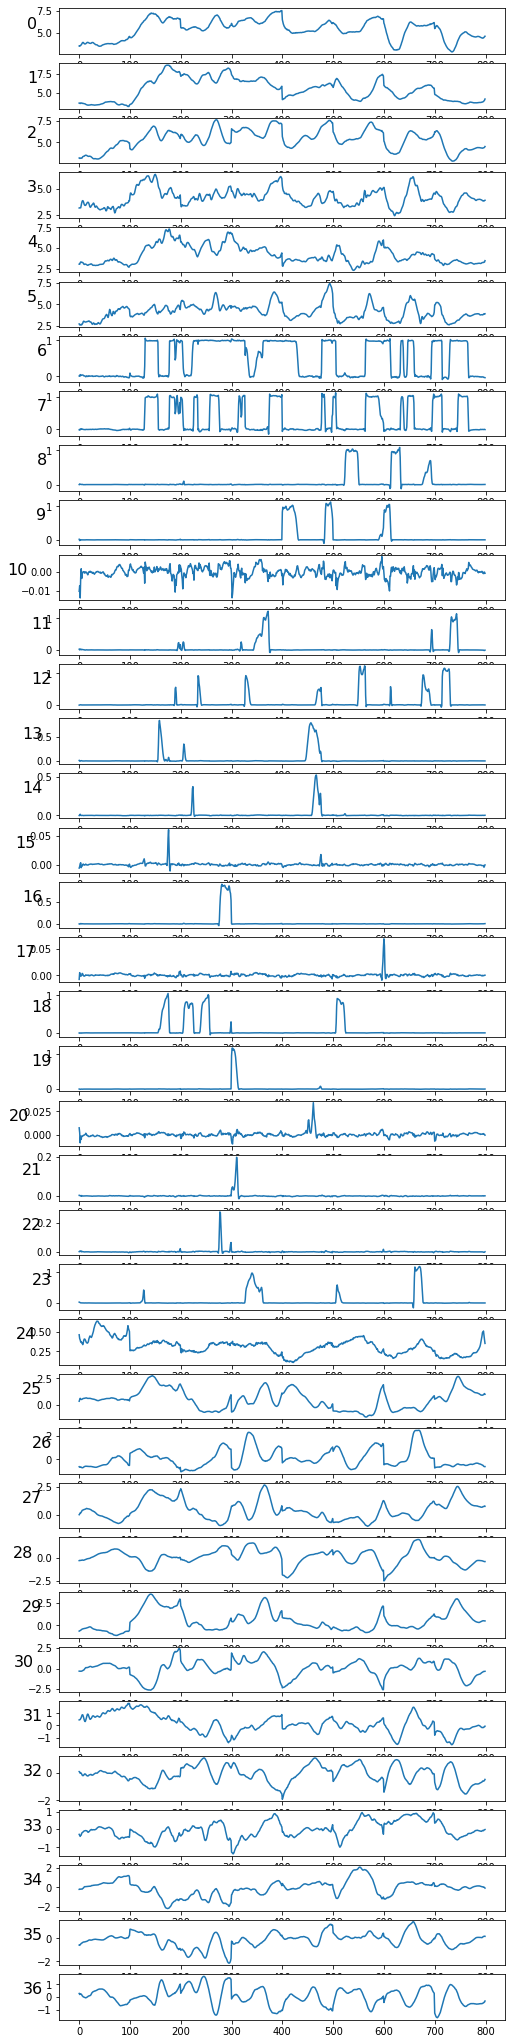

In [9]:
# plot estimated EMA sequence
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=pred.shape[1], ncols=1, figsize=(8,pred.shape[1]))
for art_i in range(pred.shape[1]):
      axes[art_i].plot(pred.cpu().numpy()[:, art_i])
      axes[art_i].set_ylabel('%d' % art_i, fontsize=16, rotation=0)

# EMA-to-Speech

In [11]:
# Load EMA-to-Speech model
synthesis_checkpoint_path = "../exp/mocha_train_rd3pmf8nema_mocha2w_hifi_rd3pm/checkpoint-105000steps.pkl"
synthesis_config_path = "../exp/mocha_train_rd3pmf8nema_mocha2w_hifi_rd3pm/config.yml"

# load config
with open(synthesis_config_path) as f:
    synthesis_config = yaml.load(f, Loader=yaml.Loader)

if torch.cuda.is_available():
    synthesis_device = torch.device("cuda")
else:
    synthesis_device = torch.device("cpu")
synthesis_model = load_model(synthesis_checkpoint_path, synthesis_config)
synthesis_model.remove_weight_norm()
synthesis_model = synthesis_model.eval().to(synthesis_device)

In [12]:
# Predict waveform for given EMA sequence
output_wav_path = "temp_w2rd2w.wav"

with torch.no_grad():
    c = torch.tensor(pred, dtype=torch.float).to(synthesis_device)
    y = ar_loop(synthesis_model, c, synthesis_config)
    sf.write(
        output_wav_path,
        y.cpu().numpy(),
        synthesis_config["sampling_rate"],
        "PCM_16",
    )


/tmp/ipykernel_119429/1465118547.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c = torch.tensor(pred, dtype=torch.float).to(synthesis_device)


In [20]:
IPython.display.Audio(output_wav_path)


In [18]:
# Predict waveform for given EMA sequence
output_wav_path = "temp8.wav"

# pred has shape (seq_len, 31)

pred_p = pred.cpu().numpy().copy()
pred_p[:, 25:31] = -1.0

with torch.no_grad():
    c = torch.tensor(pred_p, dtype=torch.float).to(synthesis_device)
    y = ar_loop(synthesis_model, c, synthesis_config)
    sf.write(
        output_wav_path,
        y.cpu().numpy(),
        synthesis_config["sampling_rate"],
        "PCM_16",
    )


# EMA-to-Mel-to-Speech

In [6]:
# Load EMA-to-Speech model
synthesis_checkpoint_path = "../exp/mocha_train_rd3pmf8nema_mocha2m_tr_rd3pm/checkpoint-130000steps.pkl"
synthesis_config_path = "../exp/mocha_train_rd3pmf8nema_mocha2m_tr_rd3pm/config.yml"

# load config
with open(synthesis_config_path) as f:
    synthesis_config = yaml.load(f, Loader=yaml.Loader)

if torch.cuda.is_available():
    synthesis_device = torch.device("cuda")
else:
    synthesis_device = torch.device("cpu")
synthesis_model = load_model(synthesis_checkpoint_path, synthesis_config)
synthesis_model.remove_weight_norm()
synthesis_model = synthesis_model.eval().to(synthesis_device)

In [7]:
with torch.no_grad():
    c = pred.clone().detach()
    c = c.transpose(0, 1)
    c = c.unsqueeze(0)
    mel_p = synthesis_model(c)
    print(mel_p.shape)

torch.Size([1, 80, 800])


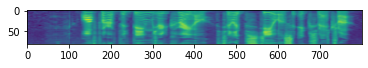

In [8]:
plt.imshow(mel_p[0].cpu().numpy())

In [9]:
# Load EMA-to-Speech model
vocoder_checkpoint_path = "../exp/mocha_train_rd3pmf8nema_m2s_mocha/checkpoint-830000steps.pkl"
vocoder_config_path = "../exp/mocha_train_rd3pmf8nema_m2s_mocha/config.yml"

# load config
with open(vocoder_config_path) as f:
    vocoder_config = yaml.load(f, Loader=yaml.Loader)

if torch.cuda.is_available():
    vocoder_device = torch.device("cuda")
else:
    vocoder_device = torch.device("cpu")
vocoder_model = load_model(vocoder_checkpoint_path, vocoder_config)
vocoder_model.remove_weight_norm()
vocoder_model = vocoder_model.eval().to(vocoder_device)

In [10]:
# Predict waveform for given EMA sequence
output_wav_path = "temp_w2e2m2w.wav"

with torch.no_grad():
    print(mel_p[0].shape)
    y = ar_loop(vocoder_model, mel_p[0].transpose(0, 1), vocoder_config)
    sf.write(
        output_wav_path,
        y.cpu().numpy(),
        vocoder_config["sampling_rate"],
        "PCM_16",
    )


torch.Size([80, 800])
